In [ ]:
!nvidia-smi

Sun Sep 20 11:20:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf data.zip data

In [ ]:
# !wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/ETCbjEkUyvhPpdqhg0E0V3YBJeN_Uq2oRDLJI2jSdKKzUw?download=1

# data1
# !wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/EUQfdEOSdZlCrVzLjTD6aXgB-NunLAsKNF9XaiVQ1f8r-Q?download=1

# data2
# !wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/EXGkNZ3LrCNFlj-mdJZbWjgBCCQzBdVRszfSzLkuDtSrmQ?download=1

# data3
# !wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/EXQuNXRqWGBKvT6AfO3c4JwBQANwZOwWwNwSV8mEnk-otw?download=1

# data4
# !wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/EX11DJeFyNVJnsIGqazrgegBCcMMQjGQ3vScdzs3zy23Rw?download=1

# data5
# !wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/EaorOODsCOBDg6VxAWx0K9UBP4a1MXXGBCKTmpBZPtLt2Q?download=1

# data6
!wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/EcHpcI4XRINOgeDQokK9DDMBYbw2X4i7Z4OV4EhTrJB9Ww?download=1

!unzip data.zip

In [ ]:
!pip install fastai --upgrade

In [ ]:
#export
import torch
import torch.nn as nn
from fastai.vision.all import (
    L, Path, TensorCategory, Category,
    Transform, Pipeline, ToTensor, Normalize, Resize, IntToFloatTensor,
    PILImage, PILImageBW, Image, ResizeMethod, PadMode,
    Categorize,
    RandomSplitter,
    Datasets,
    Learner,
    get_image_files,
    show_image,
    Metric,
    TensorImage,
    load_learner,
)
import random
import numpy as np
import re

# Seed all

In [ ]:
#export
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Load data

In [ ]:
#export
def label_func(path: Path):
    """
    Read label from file name
    :param path: path of file
    :return: label
    """
    return list(path.name.split('.')[0])

In [ ]:
#export
class CategorizeList(Categorize):
    def __init__(self, vocab=None, add_na=False, blank='-'):
        super(CategorizeList, self).__init__(vocab=vocab, add_na=add_na, sort=False,)
        self.blank = blank

    @property
    def blank_idx(self):
        return self.vocab.o2i[self.blank]

    @property
    def n_classes(self):
        return len(self.vocab.items)

    def setups(self, dsets):
        dsets = sum(dsets, L(self.blank))
        super(CategorizeList, self).setups(dsets=dsets)

    def encodes(self, os):
        return TensorCategory([self.vocab.o2i[o] for o in os])

    def decodes(self, os, raw=False):
        s = ''.join([self.vocab[o] for o in os])
        if not raw:
            s = re.sub(self.blank, '', re.sub(r'(\w)\1+', r'\1', s))

        return Category(s)


In [ ]:
#export
class BeforeBatchTransform(Transform):
    """
    Resize image before create batch
    """
    def __init__(self, height=32, width=32 * 5, keep_ratio=False, min_ratio=5.):
        super(BeforeBatchTransform, self).__init__()
        self.height, self.width = height, width
        self.keep_ratio, self.min_ratio = keep_ratio, min_ratio

    def encodes(self, items):
        images, *labels = zip(*items)
        
        height, width = self.height, self.width

        if self.keep_ratio:
            max_ratio = self.min_ratio
            for image in images:
                w, h = image.size
                max_ratio = max(max_ratio, w / h)
            width = int(np.floor(height * max_ratio))

        rs_tfm = Resize(size=(height, width), method=ResizeMethod.Pad, pad_mode=PadMode.Border)
        images = [rs_tfm(image) for image in images]
        return zip(images, *labels)

In [ ]:
#export
class CreateBatchTransform(Transform):
    """
    Create batch
    """
    def __init__(self):
        super(CreateBatchTransform, self).__init__()
        self.pipeline = Pipeline(funcs=[ToTensor,])

    def encodes(self, items):
        images, *labels = zip(*items)

        # process images
        images = self.pipeline(images)
        xs = TensorImage(torch.stack(images, dim=0))

        # process labels
        if len(labels) > 0:
            ys = labels[0]
            y_lengths = torch.LongTensor([y.size(0) for y in ys])
            ys = torch.cat(ys, dim=0)
            return xs, (ys, y_lengths)
        return xs,

## Test load data

In [ ]:
data_path = Path('data/images')
# data_path = Path('data/kaggle_data/samples')

In [ ]:
f_names = get_image_files(data_path)

In [ ]:
item_tfms = [PILImage.create, ]
y_tfms = [label_func, CategorizeList(add_na=True),]

ds = Datasets(
    items=f_names,
    tfms=[
        item_tfms,
        y_tfms,
    ],
    n_inp=1,
)

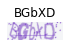

In [ ]:
ds.show(ds[0])

In [ ]:
x, y = ds[0]

In [ ]:
x, y

(PILImage mode=RGB size=160x50, TensorCategory([2, 3, 4, 5, 6]))

In [ ]:
dl = ds.dataloaders(
    bs=8,
    before_batch=BeforeBatchTransform(keep_ratio=True),
    create_batch=CreateBatchTransform(),
    after_batch=[
        IntToFloatTensor(), 
        Normalize.from_stats([0.5] * 3, [0.5] * 3),
    ]
)

In [ ]:
x, y = dl.one_batch()

In [ ]:
x.size()

torch.Size([8, 3, 32, 160])

In [ ]:
y[0], y[1]

(TensorCategory([47, 16,  9, 51, 31, 37, 41, 23, 43,  3, 23, 61, 10, 17, 25,  3, 23, 55,
         51, 61, 41, 11, 17, 34, 17, 12, 52, 24, 39, 46,  7, 57, 25, 40, 56, 14,
         30, 25,  4, 31], device='cuda:0'),
 TensorCategory([5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0'))

In [ ]:
# test_dl = dl.test_dl([Path('2b827.png')], with_labels=False)

In [ ]:
# test_dl.one_batch()

# Model

## CNN model

In [ ]:
#export
def conv_block(in_c, out_c, ks, stride, p, bn=False, leaky_relu=False):
    layers = list()
    layers.append(nn.Conv2d(
        in_channels=in_c,
        out_channels=out_c,
        kernel_size=ks,
        stride=stride,
        padding=p,
    ))

    if bn:
        layers.append(nn.BatchNorm2d(num_features=out_c))

    if leaky_relu:
        layers.append(nn.LeakyReLU(0.2, True))
    else:
        layers.append(nn.ReLU())
    return layers

class CNN(nn.Module):
    def __init__(self, in_channels=3, leaky_relu=False,):
        super(CNN, self).__init__()
        ks = [3, 3, 3, 3, 3, 3, 2]
        s  = [1, 1, 1, 1, 1, 1, 1]
        p  = [1, 1, 1, 1, 1, 1, 0]
        c  = [64, 128, 256, 256, 512, 512, 512]
        mp = [(2, 2), (2, 2), None, ((1, 2), 2), None, ((1, 2), 2), None]
        bn = [False, False, False, False, True, True, False]

        layers = []
        for i in range(len(ks)):
            in_c = in_channels if i == 0 else c[i - 1]
            layers.extend(conv_block(in_c=in_c, out_c=c[i], ks=ks[i], stride=s[i], p=p[i], bn=bn[i], leaky_relu=leaky_relu))
            if mp[i] is not None:
                kernel_size, stride = mp[i]
                layers.append(nn.MaxPool2d(kernel_size=kernel_size, stride=stride))

        self.cnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.cnn(x)
        return out

## RNN model

In [ ]:
#export
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_first=False, bidirectional=True):
        super(RNN, self).__init__()
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.batch_first, self.bidirectional = batch_first, bidirectional

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=bidirectional,
            batch_first=batch_first,
        )

        self.h2o = nn.Linear(in_features=hidden_size * 2 if bidirectional else hidden_size, out_features=output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.h2o(out)

## CRNN model = CNN + RNN

In [ ]:
#export
class CRNN(nn.Module):
    def __init__(self, in_channels, rnn_hidden_size, n_classes, leaky_relu=False):
        super(CRNN, self).__init__()
        self.cnn = CNN(in_channels=in_channels, leaky_relu=leaky_relu)
        self.rnn = nn.Sequential(
            RNN(
                input_size=512,
                hidden_size=rnn_hidden_size,
                output_size=rnn_hidden_size,
                batch_first=False,
                bidirectional=True
            ),
            RNN(
                input_size=rnn_hidden_size,
                hidden_size=rnn_hidden_size,
                output_size=n_classes,
                batch_first=False,
                bidirectional=True
            ),
        )

    def forward(self, x):
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.squeeze(2).permute(2, 0, 1)
        rnn_out = self.rnn(cnn_out)
        return rnn_out

## CTC Loss

In [ ]:
#export
class CTCLoss(nn.Module):
    def __init__(self, blank=0):
        super(CTCLoss, self).__init__()
        self.ctc_loss = nn.CTCLoss(blank=blank, zero_infinity=True)

    def forward(self, output, target):
        T, N, C = output.size()
        target, target_lengths = target
        output_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long, device=output.device)
        output = output.log_softmax(2)
        return self.ctc_loss(output, target, output_lengths, target_lengths)

## Accuracy metric

In [ ]:
#export
class AccMetric(Metric):
    def __init__(self):
        self.y_true, self.y_pred = [], []

    def reset(self):
        self.y_true, self.y_pred = [], []

    def accumulate(self, learn):
        label_categorize = learn.dls.tfms[1][-1]
        yb_pred = learn.pred.permute(1, 0, 2).argmax(dim=2)
        (yb, y_lengths), = learn.yb

        yb = torch.split(yb, y_lengths.cpu().tolist())
        self.y_true.extend([label_categorize.decode(y, raw=True) for y in yb])

        self.y_pred.extend([label_categorize.decode(y) for y in yb_pred])

    @property
    def value(self):
#         print(self.y_pred[:4], self.y_true[:4])
        n_correct = (np.array(self.y_pred) == np.array(self.y_true)).sum()
        return n_correct / float(len(self.y_true))

    @property
    def name(self):
        return 'accuracy'


### Test model and loss func

In [ ]:
model = CRNN(in_channels=3, rnn_hidden_size=256, n_classes=ds.tfms[1][-1].n_classes, leaky_relu=True,)
model = model.cuda()

In [ ]:
out = model(x)
out.size()

torch.Size([9, 8, 64])

In [ ]:
loss_func = CTCLoss(blank=ds.tfms[1][-1].blank_idx)

In [ ]:
loss_func(out, y)

tensor(6.0912, device='cuda:0', grad_fn=<MeanBackward0>)

# Train model

## Config

In [ ]:
#export
data_path = Path('data/images')
# data_path = Path('data/kaggle_data/samples')
bs = 256

In [ ]:
#export
model_dir = Path('drive/My Drive/models/ocr_crnn_captcha')

## Load data

In [ ]:
#export
f_names = get_image_files(data_path)

(#293114) [Path('data/images/zc5cllzq.png'),Path('data/images/tte2lle.png'),Path('data/images/92101808.png'),Path('data/images/363118.png'),Path('data/images/4248242.png'),Path('data/images/43159.png'),Path('data/images/65875470.png'),Path('data/images/32799.png'),Path('data/images/w07q8.png'),Path('data/images/075721.png')...]

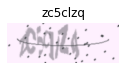

In [ ]:
#export
item_tfms = [PILImage.create, ]
y_tfms = [label_func, CategorizeList(add_na=False),]

ds = Datasets(
    items=f_names,
    tfms=[
        item_tfms,
        y_tfms,
    ],
    splits=RandomSplitter(valid_pct=0.2, seed=42)(f_names),
)
ds.show(ds[0])

In [ ]:
#export
dls = ds.dataloaders(
    bs=bs,
    before_batch=BeforeBatchTransform(keep_ratio=True),
    create_batch=CreateBatchTransform(),
    after_batch=[IntToFloatTensor, Normalize.from_stats([0.5] * 3, [0.5] * 3)],
)

In [ ]:
# dls.one_batch()

## Create model

In [ ]:
#export
model = CRNN(in_channels=3, rnn_hidden_size=256, n_classes=ds.tfms[1][-1].n_classes, leaky_relu=False)
loss_func = CTCLoss(blank=ds.tfms[1][-1].blank_idx)

In [ ]:
ds.tfms[1][-1].vocab

(#37) ['-','x','n','s','b','o','q','e','d','2'...]

## Create learner

In [ ]:
#export
learner = Learner(
    dls=dls,
    model=model,
    loss_func=loss_func,
    metrics=[AccMetric()]
)

In [ ]:
learner = learner.to_fp16()

## Training

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0002754228771664202)

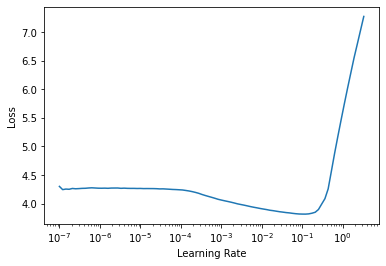

In [ ]:
#export
# learning rate finder
learner.lr_find()

In [ ]:
#export
# fit one cycle
learner.fit_one_cycle(30, lr=1e-3)

In [ ]:
#export
learner.model_dir = model_dir
learner.save('captcha_6271_data6')

Path('drive/My Drive/models/ocr_crnn_captcha/captcha_6271_data6.pth')

In [ ]:
#export
learner.export(model_dir/'captcha_6271_data6.pkl')

## Predict


### Load learner

In [ ]:
#export
learner = load_learner(model_dir/'captcha_6271_data6.pkl')

### Load test_dl

In [ ]:
#export
test_files = get_image_files('data/test_images')

In [ ]:
#export
test_dl = learner.dls.test_dl(test_files, with_labels=True)

In [ ]:
test_dl.one_batch()[0].size()

torch.Size([256, 3, 32, 160])

### Get predictions

In [ ]:
#export
learner.validate(dl=test_dl)

(#2) [0.231215238571167,0.8594556308813114]

In [ ]:
test_dl = learner.dls.test_dl(test_files, with_labels=False)

In [ ]:
preds = learner.get_preds(dl=test_dl, reorder=False,concat_dim=1)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
# pred = preds[0].permute(1, 0, 2)

In [ ]:
# pred_labels = [learner.dls.tfms[-1][-1].decode(preds[:,i,:].argmax(dim=-1)) for i in range(preds.size(1))]

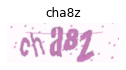

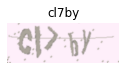

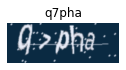

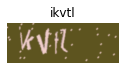

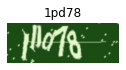

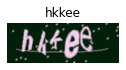

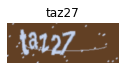

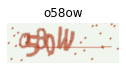

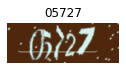

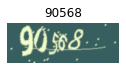

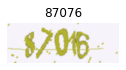

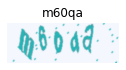

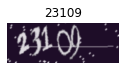

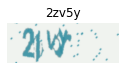

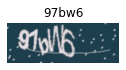

In [ ]:
for i in range(15):
    # print(pred_labels[i])
    learner.dls.dataset.show((test_dl.dataset[i], TensorCategory(preds[:,i,:].argmax(dim=-1))))

In [ ]:
learner.model(test_dl.one_batch()[0]).size()

torch.Size([9, 64, 63])

### Get prediction text

In [ ]:
[learner.dls.tfms[-1][-1].decode(preds[:,i,:].argmax(dim=-1)) for i in range(preds.size(1))]

['LC47p',
 'bnWsU',
 'qScfn',
 'vWQO',
 'o4ltD',
 'AH6Gg',
 '46mRK',
 'pTJ3P',
 'OVTZN',
 '6ZLPn',
 'GeQQf',
 'eJVU9',
 'oVnR',
 'b232D',
 'yLl8I',
 '6Nqul',
 'l6VKZ',
 'cSHMU',
 'Rpq3u',
 '10Plo',
 '0bziv',
 'WRRQh',
 'xuwsa',
 'cRWh',
 'GOC9q',
 'jZsBx',
 'KvDW1',
 'Xw0jF',
 'w5jeT',
 'YWxi4',
 'X12sn',
 'vBGLc',
 'qhxQP',
 'YJE4U',
 'ZDzAI',
 'h4rXq',
 'pvJD',
 'fI4r2',
 'UaeXd',
 'KYRVW',
 'hqYzt',
 'HYcL9',
 'pYnlc',
 'oiamg',
 'h0Cej',
 'lqwn',
 '6NJBr',
 'PTPZh',
 'WekED',
 'cLuNH',
 'WiZE3',
 'KYWfJ',
 'hC0xS',
 'FIqoG',
 'BrcRT',
 'HQsXT',
 'TopXU',
 'HNSOL',
 'sJfo',
 '6H9q0',
 'KyQZ2',
 'dySiU',
 'TepVt',
 'eqmYG',
 'vYyhu',
 'hrNGD',
 'lSm4A',
 'iCXFZ',
 'AgUp5',
 '4NPAt',
 '97YL4',
 'vgbFe',
 'eiDn4',
 '2DPxc',
 '5voq1',
 'I3tu',
 'VBvMt',
 'OuDQm',
 'wWwbb',
 'eBidf',
 'u2cOh',
 'htrgM',
 'omVxk',
 'dEziM',
 'BaOEN',
 'epljH',
 'UOM53',
 'a2x7O',
 'Dw8Rj',
 'IaLJo',
 '0LGjX',
 '3Qkfy',
 '1HoMS',
 'a6f7B',
 'SR0am',
 'VGIEF',
 'RvwEQ',
 'KGcOe',
 'l6CSH',
 'ZvGmY',
 'NIiKY

### Test with transparent background image

In [ ]:
test_dl = learner.dls.test_dl(L(['33356.png', '05226.png', '98348.png', '2b827.png']))
# x = test_dl.one_batch()[0]

In [ ]:
preds = learner.get_preds(dl=test_dl, reorder=False, concat_dim=1)[0]
preds.size()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


torch.Size([9, 4, 37])

In [ ]:
[learner.dls.tfms[-1][-1].decode(preds[:,i,:].argmax(dim=-1)) for i in range(preds.size(1))]

['33356', '05226', '98348', 'y3rxxz']

# Test resize

In [ ]:
rs = Resize((32, 160), pad_mode=PadMode.Border, method=ResizeMethod.Pad)

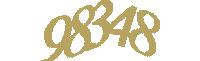

In [ ]:
img = PILImage.create('98348.png')
img

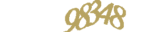

In [ ]:
rs(img)